We shall now build and train a Convolutional Neural Network on the augmented Oxford IIIT Pet Dataset, we'll use the dataset r1.

In [2]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import matplotlib.pyplot as plt

# Data loading

We shall use the Dataset class to build a custom dataset class inheriting from it.

In [3]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255    # not using read_image coz it can only read jpeg or png
        image = image[:,:,:3]  # dropping the alpha channel if any
        class_label = self.img_annotations.iloc[idx,2]-1      # the -1 is coz labels are expected from 0 to C-1
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label

Let's define the transforms, read_image already reads the images as tensors so we don't need to use ToTensor, we shall only resize the images to (size,size) pixels. We shall use the NLL Loss later, this expects as target a class index ranging from 0 to C-1. So we don't need one-hot encoding for the target, but in principle we could do it as shown below. 

In [4]:
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize])     # totensor has to be applied first and then resize coz the latter doesn't work on numpy arrays
#label_transform_one_hot = T.Lambda(lambda y: torch.zeros(37, dtype=torch.float).scatter_(dim=0,index=torch.tensor(y),value=1))

In [5]:
train_r1 = PetDataset('annotations_aug/annotations_train_r1.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test.csv','img_augmented_processed/', transform = trans)

In [6]:
train_r1_loader = DataLoader(train_r1,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=len(valid),shuffle=True)
test_loader = DataLoader(test,batch_size=len(test),shuffle=True)

We can call the first batch in the following way:

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


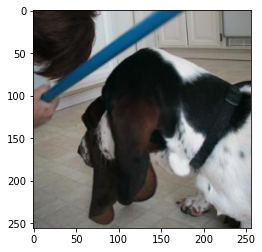

In [7]:
train_b1_img, train_b1_label = next(iter(train_r1_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
print('shape of training batch (labels): {}'.format(train_b1_label.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

# Model (6 conv layers)

In [19]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.4),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()


print(model1)
        

PetCNN6(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.4, inplace=False)
    (1): Conv2d(64, 128,

## Training on a small batch

We shall now try to train the model above on a small batch. If we are able to overtrain (achieve almost total training accuracy) on this small dataset, we'll go ahead and check if we can achieve very high training accuracy on the entire training set.

In [27]:
# Trying to overtrain on a small batch from set r1

model1 = PetCNN6()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate)


train_r1_loader_temp = DataLoader(train_r1,batch_size=256,shuffle=True)
x = next(iter(train_r1_loader_temp))

count = 0

start = time.time()

#for i in range(num_epochs):
for i in range(200):
    model1.train()       # to set the model in training mode coz batchnorm will behave differently in the eval mode
    
    out = model1(x[0].float())
    loss = loss_function(out,x[1])
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    count += 1
    
    if count%20 == 0:
        
        model1.eval()
        with torch.no_grad():
            out = model1(x[0].float())
            current_loss = loss_function(out,x[1])
            print('Iteration:{}'.format(count))
            #print(out)
            print('Loss:{}'.format(current_loss.item()))
            print('Accuracy:{}'.format((torch.max(out,1)[1]==x[1]).sum()/256))
            
        end = time.time()
        print('Time taken for the last 20 iterations: {}'.format(end-start))        # time taken for the last 20 iterations
    
            
        start = time.time()      
       
        

    


Iteration:20
Loss:3.611985683441162
Accuracy:0.03125
Time taken for the last 20 iterations: 57.301703691482544
Iteration:40
Loss:3.6104378700256348
Accuracy:0.0390625
Time taken for the last 20 iterations: 62.5105037689209
Iteration:60
Loss:3.4679336547851562
Accuracy:0.14453125
Time taken for the last 20 iterations: 62.36521553993225
Iteration:80
Loss:3.1575233936309814
Accuracy:0.421875
Time taken for the last 20 iterations: 61.93339657783508
Iteration:100
Loss:2.9201834201812744
Accuracy:0.57421875
Time taken for the last 20 iterations: 61.6844584941864
Iteration:120
Loss:2.7572784423828125
Accuracy:0.67578125
Time taken for the last 20 iterations: 63.0110878944397
Iteration:140
Loss:2.55171799659729
Accuracy:0.76953125
Time taken for the last 20 iterations: 62.28511714935303
Iteration:160
Loss:2.3424668312072754
Accuracy:0.828125
Time taken for the last 20 iterations: 61.8873929977417
Iteration:180
Loss:2.1209444999694824
Accuracy:0.87109375
Time taken for the last 20 iterations: 6

## Training on the entire dataset

We shall now check if we can overtrain our models on the entire datasets.

In [43]:
model1 = PetCNN6()
learning_rate = 0.001
decay_rate = 0.0001
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 150

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_r1_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_r1_part = DataLoader(train_r1,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_r1_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

    


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 31.375319719314575
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 34.29090714454651
Epoch:1
Iteration:150
Time taken for the last 50 iterations: 36.60094356536865
Current training loss:3.606898069381714
Current training accuracy:0.037109375
Current validation loss:3.624429225921631
Current validation accuracy:0.03487592190504074
Epoch:1
Iteration:200
Time taken for the last 50 iterations: 37.58177733421326
Current training loss:3.605029582977295
Current training accuracy:0.04736328125
Current validation loss:3.617532968521118
Current validation accuracy:0.036217302083969116
Epoch:2
Iteration:250
Time taken for the last 50 iterations: 35.8166720867157
Current training loss:3.554330587387085
Current training accuracy:0.06396484375
Current validation loss:3.5496418476104736
Current validation accuracy:0.07109322398900986
Epoch:2
Iteration:300
Time taken for the last 50 iterations: 36.466203451156616
Current training

Current training loss:2.792915105819702
Current training accuracy:0.2490234375
Current validation loss:2.9204187393188477
Current validation accuracy:0.2059020847082138
Epoch:16
Iteration:1800
Time taken for the last 50 iterations: 36.15915250778198
Current training loss:2.745598077774048
Current training accuracy:0.24267578125
Current validation loss:2.8819475173950195
Current validation accuracy:0.1951710283756256
Epoch:16
Iteration:1850
Time taken for the last 50 iterations: 39.06407380104065
Current training loss:2.8368139266967773
Current training accuracy:0.21826171875
Current validation loss:2.9799365997314453
Current validation accuracy:0.17572098970413208
Epoch:16
Iteration:1900
Time taken for the last 50 iterations: 39.816022872924805
Current training loss:2.701770305633545
Current training accuracy:0.248046875
Current validation loss:2.8642654418945312
Current validation accuracy:0.2005365490913391
Epoch:17
Iteration:1950
Time taken for the last 50 iterations: 38.24607610702

Epoch:30
Iteration:3400
Time taken for the last 50 iterations: 35.36908507347107
Current training loss:2.0855863094329834
Current training accuracy:0.4501953125
Current validation loss:2.5463833808898926
Current validation accuracy:0.2917504906654358
Epoch:30
Iteration:3450
Time taken for the last 50 iterations: 35.927753925323486
Current training loss:2.0432021617889404
Current training accuracy:0.46142578125
Current validation loss:2.51533579826355
Current validation accuracy:0.3071763813495636
Epoch:31
Iteration:3500
Time taken for the last 50 iterations: 36.16945457458496
Current training loss:2.1037018299102783
Current training accuracy:0.43798828125
Current validation loss:2.540353536605835
Current validation accuracy:0.2917504906654358
Epoch:31
Iteration:3550
Time taken for the last 50 iterations: 36.02987766265869
Current training loss:2.0143611431121826
Current training accuracy:0.45556640625
Current validation loss:2.5544071197509766
Current validation accuracy:0.281019449234

Current validation loss:2.3922693729400635
Current validation accuracy:0.33199194073677063
Epoch:45
Iteration:5050
Time taken for the last 50 iterations: 35.5260443687439
Current training loss:1.554153561592102
Current training accuracy:0.6142578125
Current validation loss:2.3940629959106445
Current validation accuracy:0.34272301197052
Epoch:45
Iteration:5100
Time taken for the last 50 iterations: 36.18901562690735
Current training loss:1.5764167308807373
Current training accuracy:0.615234375
Current validation loss:2.4002556800842285
Current validation accuracy:0.33668678998947144
Epoch:45
Iteration:5150
Time taken for the last 50 iterations: 36.09338665008545
Current training loss:1.5534931421279907
Current training accuracy:0.615234375
Current validation loss:2.3839974403381348
Current validation accuracy:0.33601608872413635
Epoch:46
Iteration:5200
Time taken for the last 50 iterations: 35.63394236564636
Current training loss:1.595381259918213
Current training accuracy:0.58544921875

Current validation loss:2.2633752822875977
Current validation accuracy:0.3648557960987091
Epoch:59
Iteration:6700
Time taken for the last 50 iterations: 36.33649468421936
Current training loss:1.205484390258789
Current training accuracy:0.71484375
Current validation loss:2.327981948852539
Current validation accuracy:0.34071093797683716
Epoch:60
Iteration:6750
Time taken for the last 50 iterations: 35.39997434616089
Current training loss:1.1650453805923462
Current training accuracy:0.73828125
Current validation loss:2.321462631225586
Current validation accuracy:0.35680750012397766
Epoch:60
Iteration:6800
Time taken for the last 50 iterations: 36.09952998161316
Current training loss:1.1203161478042603
Current training accuracy:0.7607421875
Current validation loss:2.2705740928649902
Current validation accuracy:0.3601609766483307
Epoch:61
Iteration:6850
Time taken for the last 50 iterations: 35.405959606170654
Current training loss:1.1718109846115112
Current training accuracy:0.744140625
C

Current validation loss:2.3363418579101562
Current validation accuracy:0.36217305064201355
Epoch:74
Iteration:8350
Time taken for the last 50 iterations: 36.2607684135437
Current training loss:0.8828316330909729
Current training accuracy:0.841796875
Current validation loss:2.295142650604248
Current validation accuracy:0.36686787009239197
Epoch:74
Iteration:8400
Time taken for the last 50 iterations: 35.59336471557617
Current training loss:0.8702494502067566
Current training accuracy:0.837890625
Current validation loss:2.2951672077178955
Current validation accuracy:0.36753857135772705
Epoch:75
Iteration:8450
Time taken for the last 50 iterations: 36.37576913833618
Current training loss:0.8751708269119263
Current training accuracy:0.82080078125
Current validation loss:2.313683271408081
Current validation accuracy:0.3769282400608063
Epoch:75
Iteration:8500
Time taken for the last 50 iterations: 36.06414079666138
Current training loss:0.8445270657539368
Current training accuracy:0.85351562

Current training loss:0.7118316888809204
Current training accuracy:0.88720703125
Current validation loss:2.289842128753662
Current validation accuracy:0.3641851246356964
Epoch:89
Iteration:10000
Time taken for the last 50 iterations: 35.504733085632324
Current training loss:0.6789228320121765
Current training accuracy:0.8935546875
Current validation loss:2.292881965637207
Current validation accuracy:0.37961098551750183
Epoch:89
Iteration:10050
Time taken for the last 50 iterations: 36.285828828811646
Current training loss:0.6565598845481873
Current training accuracy:0.88818359375
Current validation loss:2.2844350337982178
Current validation accuracy:0.37961098551750183
Epoch:90
Iteration:10100
Time taken for the last 50 iterations: 35.518667459487915
Current training loss:0.7195059657096863
Current training accuracy:0.88818359375
Current validation loss:2.3310816287994385
Current validation accuracy:0.3755868673324585
Epoch:90
Iteration:10150
Time taken for the last 50 iterations: 35.9

Epoch:103
Iteration:11600
Time taken for the last 50 iterations: 36.297022104263306
Current training loss:0.5465970039367676
Current training accuracy:0.93359375
Current validation loss:2.2942287921905518
Current validation accuracy:0.38430583477020264
Epoch:104
Iteration:11650
Time taken for the last 50 iterations: 35.544315814971924
Current training loss:0.5517309904098511
Current training accuracy:0.92431640625
Current validation loss:2.2738678455352783
Current validation accuracy:0.37290409207344055
Epoch:104
Iteration:11700
Time taken for the last 50 iterations: 36.35203957557678
Current training loss:0.5906611084938049
Current training accuracy:0.9169921875
Current validation loss:2.313143253326416
Current validation accuracy:0.36351442337036133
Epoch:104
Iteration:11750
Time taken for the last 50 iterations: 36.26428437232971
Current training loss:0.5604889392852783
Current training accuracy:0.92529296875
Current validation loss:2.294989585876465
Current validation accuracy:0.36

Current validation loss:2.2905845642089844
Current validation accuracy:0.37357479333877563
Epoch:118
Iteration:13250
Time taken for the last 50 iterations: 35.635281801223755
Current training loss:0.49989378452301025
Current training accuracy:0.94287109375
Current validation loss:2.3108553886413574
Current validation accuracy:0.3749161660671234
Epoch:118
Iteration:13300
Time taken for the last 50 iterations: 36.379692792892456
Current training loss:0.49694177508354187
Current training accuracy:0.9453125
Current validation loss:2.2855286598205566
Current validation accuracy:0.37424546480178833
Epoch:119
Iteration:13350
Time taken for the last 50 iterations: 35.59451127052307
Current training loss:0.439504474401474
Current training accuracy:0.9560546875
Current validation loss:2.2855396270751953
Current validation accuracy:0.37961098551750183
Epoch:119
Iteration:13400
Time taken for the last 50 iterations: 36.24996304512024
Current training loss:0.44132548570632935
Current training accur

Epoch:132
Iteration:14850
Time taken for the last 50 iterations: 35.82287955284119
Current training loss:0.3975839614868164
Current training accuracy:0.95947265625
Current validation loss:2.321643352508545
Current validation accuracy:0.37424546480178833
Epoch:133
Iteration:14900
Time taken for the last 50 iterations: 35.335243225097656
Current training loss:0.3873863220214844
Current training accuracy:0.96533203125
Current validation loss:2.349210500717163
Current validation accuracy:0.3702213168144226
Epoch:133
Iteration:14950
Time taken for the last 50 iterations: 36.25670528411865
Current training loss:0.3841448724269867
Current training accuracy:0.96484375
Current validation loss:2.295818567276001
Current validation accuracy:0.380952388048172
Epoch:133
Iteration:15000
Time taken for the last 50 iterations: 36.125218868255615
Current training loss:0.33910688757896423
Current training accuracy:0.97265625
Current validation loss:2.294083595275879
Current validation accuracy:0.39168342

Current validation loss:2.288163661956787
Current validation accuracy:0.38363513350486755
Epoch:147
Iteration:16500
Time taken for the last 50 iterations: 35.62301015853882
Current training loss:0.3370714783668518
Current training accuracy:0.966796875
Current validation loss:2.3083086013793945
Current validation accuracy:0.3655264973640442
Epoch:147
Iteration:16550
Time taken for the last 50 iterations: 36.033512592315674
Current training loss:0.3333851993083954
Current training accuracy:0.97314453125
Current validation loss:2.3043322563171387
Current validation accuracy:0.3822937607765198
Epoch:148
Iteration:16600
Time taken for the last 50 iterations: 35.56843113899231
Current training loss:0.360535204410553
Current training accuracy:0.97021484375
Current validation loss:2.3430893421173096
Current validation accuracy:0.37290409207344055
Epoch:148
Iteration:16650
Time taken for the last 50 iterations: 36.31970191001892
Current training loss:0.3141939043998718
Current training accuracy

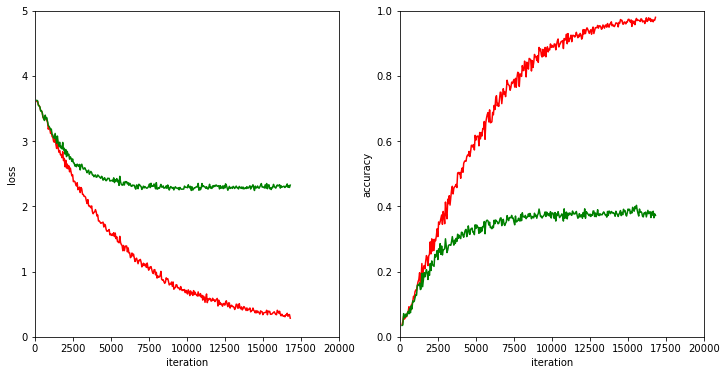

In [44]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,20000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,20000)
acc_graph.set_ylim(0,1)

plt.show()               


# Model (5 conv layers, more channels)

In [11]:
class PetCNN5(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=4,stride=2),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.4),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=2, stride=1),                                    
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(512, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    

loss_function = nn.NLLLoss()


model1 = PetCNN5()
print(model1)



PetCNN5(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2))
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.4, inplace=False)
    (1): Conv2d(128

In [12]:
learning_rate = 0.001
decay_rate = 0.0001
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 250

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_r1_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_r1_part = DataLoader(train_r1,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_r1_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()

        

Epoch:0
Iteration:50
Time taken for the last 50 iterations: 11.297582864761353
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 12.341032028198242
Epoch:1
Iteration:150
Time taken for the last 50 iterations: 13.462271451950073
Current training loss:3.4427945613861084
Current training accuracy:0.07080078125
Current validation loss:3.4364004135131836
Current validation accuracy:0.07981220632791519
Epoch:1
Iteration:200
Time taken for the last 50 iterations: 13.692909955978394
Current training loss:3.375396490097046
Current training accuracy:0.08056640625
Current validation loss:3.373863935470581
Current validation accuracy:0.08651911467313766
Epoch:2
Iteration:250
Time taken for the last 50 iterations: 11.316335201263428
Current training loss:3.37990140914917
Current training accuracy:0.0888671875
Current validation loss:3.418999433517456
Current validation accuracy:0.07243460416793823
Epoch:2
Iteration:300
Time taken for the last 50 iterations: 13.931103467941284
Current tra

Current training loss:2.7728607654571533
Current training accuracy:0.20703125
Current validation loss:2.993295431137085
Current validation accuracy:0.16096580028533936
Epoch:16
Iteration:1800
Time taken for the last 50 iterations: 13.636195659637451
Current training loss:2.815464973449707
Current training accuracy:0.19287109375
Current validation loss:2.9263551235198975
Current validation accuracy:0.15492957830429077
Epoch:16
Iteration:1850
Time taken for the last 50 iterations: 13.92348051071167
Current training loss:2.6639904975891113
Current training accuracy:0.2392578125
Current validation loss:2.846475124359131
Current validation accuracy:0.18645204603672028
Epoch:16
Iteration:1900
Time taken for the last 50 iterations: 13.904271125793457
Current training loss:2.6064395904541016
Current training accuracy:0.26171875
Current validation loss:2.793952465057373
Current validation accuracy:0.19986586272716522
Epoch:17
Iteration:1950
Time taken for the last 50 iterations: 13.549251317977

Epoch:30
Iteration:3400
Time taken for the last 50 iterations: 13.335815906524658
Current training loss:2.329596757888794
Current training accuracy:0.3583984375
Current validation loss:2.679408550262451
Current validation accuracy:0.24077799916267395
Epoch:30
Iteration:3450
Time taken for the last 50 iterations: 14.021376609802246
Current training loss:2.3306870460510254
Current training accuracy:0.3408203125
Current validation loss:2.6540582180023193
Current validation accuracy:0.2380952388048172
Epoch:31
Iteration:3500
Time taken for the last 50 iterations: 13.644161701202393
Current training loss:2.32344913482666
Current training accuracy:0.34033203125
Current validation loss:2.663118600845337
Current validation accuracy:0.24010731279850006
Epoch:31
Iteration:3550
Time taken for the last 50 iterations: 13.9228196144104
Current training loss:2.2535111904144287
Current training accuracy:0.369140625
Current validation loss:2.6196110248565674
Current validation accuracy:0.25016766786575

Current validation loss:2.661679744720459
Current validation accuracy:0.2481555938720703
Epoch:45
Iteration:5050
Time taken for the last 50 iterations: 14.569685935974121
Current training loss:1.9707112312316895
Current training accuracy:0.44189453125
Current validation loss:2.5797390937805176
Current validation accuracy:0.26156941056251526
Epoch:45
Iteration:5100
Time taken for the last 50 iterations: 15.034985542297363
Current training loss:2.006089210510254
Current training accuracy:0.44580078125
Current validation loss:2.5837044715881348
Current validation accuracy:0.26291078329086304
Epoch:45
Iteration:5150
Time taken for the last 50 iterations: 13.156724691390991
Current training loss:1.9631052017211914
Current training accuracy:0.447265625
Current validation loss:2.5480687618255615
Current validation accuracy:0.2756539285182953
Epoch:46
Iteration:5200
Time taken for the last 50 iterations: 15.271296739578247
Current training loss:1.957836389541626
Current training accuracy:0.459

Current training loss:1.7445857524871826
Current training accuracy:0.5390625
Current validation loss:2.515650510787964
Current validation accuracy:0.28437289595603943
Epoch:59
Iteration:6700
Time taken for the last 50 iterations: 12.955482244491577
Current training loss:1.7307466268539429
Current training accuracy:0.52978515625
Current validation loss:2.541206121444702
Current validation accuracy:0.279678076505661
Epoch:60
Iteration:6750
Time taken for the last 50 iterations: 12.826910495758057
Current training loss:1.7503827810287476
Current training accuracy:0.52685546875
Current validation loss:2.5580132007598877
Current validation accuracy:0.28437289595603943
Epoch:60
Iteration:6800
Time taken for the last 50 iterations: 12.968218564987183
Current training loss:1.7202857732772827
Current training accuracy:0.55126953125
Current validation loss:2.524505853652954
Current validation accuracy:0.2756539285182953
Epoch:61
Iteration:6850
Time taken for the last 50 iterations: 12.8163871765

Epoch:74
Iteration:8300
Time taken for the last 50 iterations: 12.741739988327026
Current training loss:1.5067791938781738
Current training accuracy:0.6103515625
Current validation loss:2.4967920780181885
Current validation accuracy:0.2863849699497223
Epoch:74
Iteration:8350
Time taken for the last 50 iterations: 13.037109613418579
Current training loss:1.5292177200317383
Current training accuracy:0.60546875
Current validation loss:2.5192337036132812
Current validation accuracy:0.2870556712150574
Epoch:74
Iteration:8400
Time taken for the last 50 iterations: 12.685033559799194
Current training loss:1.479471206665039
Current training accuracy:0.6240234375
Current validation loss:2.493800640106201
Current validation accuracy:0.28772637248039246
Epoch:75
Iteration:8450
Time taken for the last 50 iterations: 12.968530654907227
Current training loss:1.5198798179626465
Current training accuracy:0.6171875
Current validation loss:2.524338722229004
Current validation accuracy:0.2924211919307709

Epoch:88
Iteration:9950
Time taken for the last 50 iterations: 13.13309097290039
Current training loss:1.3071388006210327
Current training accuracy:0.68701171875
Current validation loss:2.5234429836273193
Current validation accuracy:0.28437289595603943
Epoch:89
Iteration:10000
Time taken for the last 50 iterations: 12.680663347244263
Current training loss:1.2923952341079712
Current training accuracy:0.701171875
Current validation loss:2.5520548820495605
Current validation accuracy:0.2743125557899475
Epoch:89
Iteration:10050
Time taken for the last 50 iterations: 13.084606647491455
Current training loss:1.311558485031128
Current training accuracy:0.697265625
Current validation loss:2.5298471450805664
Current validation accuracy:0.290409117937088
Epoch:90
Iteration:10100
Time taken for the last 50 iterations: 12.96517300605774
Current training loss:1.263189673423767
Current training accuracy:0.712890625
Current validation loss:2.546204090118408
Current validation accuracy:0.3011401891708

Current validation loss:2.5585176944732666
Current validation accuracy:0.28236082196235657
Epoch:103
Iteration:11600
Time taken for the last 50 iterations: 13.200425863265991
Current training loss:1.1209921836853027
Current training accuracy:0.755859375
Current validation loss:2.5699102878570557
Current validation accuracy:0.28772637248039246
Epoch:104
Iteration:11650
Time taken for the last 50 iterations: 12.938479900360107
Current training loss:1.1590304374694824
Current training accuracy:0.744140625
Current validation loss:2.6032791137695312
Current validation accuracy:0.28303152322769165
Epoch:104
Iteration:11700
Time taken for the last 50 iterations: 13.192486047744751
Current training loss:1.1902421712875366
Current training accuracy:0.736328125
Current validation loss:2.591181755065918
Current validation accuracy:0.2850435972213745
Epoch:104
Iteration:11750
Time taken for the last 50 iterations: 13.747265338897705
Current training loss:1.1686569452285767
Current training accurac

KeyboardInterrupt: 

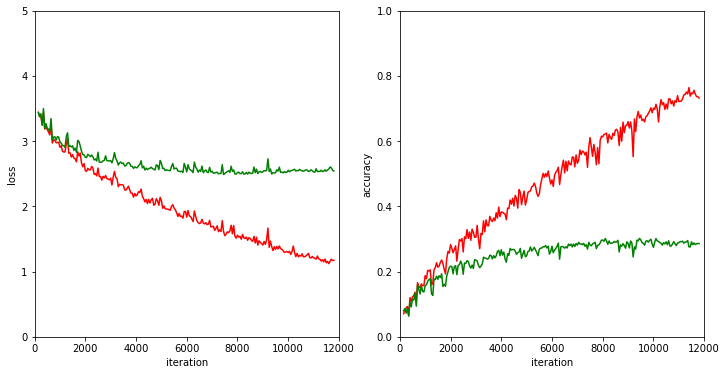

In [13]:
            
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,12000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,12000)
acc_graph.set_ylim(0,1)

plt.show() 

# Model (4 conv layers)

In [17]:
class PetCNN4(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=4, stride=2),                                    
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.4),
                                    nn.Conv2d(in_channels=32, out_channels=256, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=2, stride=1),   #default stride is kernel size                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(512, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


loss_function = nn.NLLLoss()

model1 = PetCNN4()
print(model1)


learning_rate = 0.001
decay_rate = 0.0001
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 150

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_r1_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_r1_part = DataLoader(train_r1,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_r1_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                             

            
        

    

        

PetCNN4(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 32, kernel_size=(3, 3), stride=(2, 2))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.4, inplace=False)
    (1): Conv2d(32, 256, kernel_size=(3, 3), stride=(2, 2))
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Conv2d(256, 512

Epoch:13
Iteration:1500
Time taken for the last 50 iterations: 11.9830322265625
Current training loss:2.7767064571380615
Current training accuracy:0.2392578125
Current validation loss:2.9493019580841064
Current validation accuracy:0.17035546898841858
Epoch:13
Iteration:1550
Time taken for the last 50 iterations: 12.020478963851929
Current training loss:2.7807934284210205
Current training accuracy:0.23046875
Current validation loss:2.951991319656372
Current validation accuracy:0.17840375006198883
Epoch:14
Iteration:1600
Time taken for the last 50 iterations: 11.689210891723633
Current training loss:2.7352890968322754
Current training accuracy:0.25537109375
Current validation loss:2.895261764526367
Current validation accuracy:0.18913480639457703
Epoch:14
Iteration:1650
Time taken for the last 50 iterations: 12.14757513999939
Current training loss:2.807147264480591
Current training accuracy:0.23095703125
Current validation loss:2.96580171585083
Current validation accuracy:0.17572098970413

Current validation loss:2.7137320041656494
Current validation accuracy:0.23541247844696045
Epoch:28
Iteration:3150
Time taken for the last 50 iterations: 12.683672904968262
Current training loss:2.303025960922241
Current training accuracy:0.35302734375
Current validation loss:2.737520217895508
Current validation accuracy:0.24413146078586578
Epoch:28
Iteration:3200
Time taken for the last 50 iterations: 14.934733390808105
Current training loss:2.2512640953063965
Current training accuracy:0.39404296875
Current validation loss:2.712761163711548
Current validation accuracy:0.24480214715003967
Epoch:29
Iteration:3250
Time taken for the last 50 iterations: 13.310824155807495
Current training loss:2.3609230518341064
Current training accuracy:0.359375
Current validation loss:2.7384791374206543
Current validation accuracy:0.2380952388048172
Epoch:29
Iteration:3300
Time taken for the last 50 iterations: 13.88710355758667
Current training loss:2.228095769882202
Current training accuracy:0.4111328

Current training loss:1.8825026750564575
Current training accuracy:0.521484375
Current validation loss:2.6162233352661133
Current validation accuracy:0.265593558549881
Epoch:42
Iteration:4800
Time taken for the last 50 iterations: 12.361187934875488
Current training loss:1.8790340423583984
Current training accuracy:0.515625
Current validation loss:2.6353609561920166
Current validation accuracy:0.28303152322769165
Epoch:43
Iteration:4850
Time taken for the last 50 iterations: 12.077503442764282
Current training loss:1.811854362487793
Current training accuracy:0.54345703125
Current validation loss:2.580716609954834
Current validation accuracy:0.2810194492340088
Epoch:43
Iteration:4900
Time taken for the last 50 iterations: 12.360788822174072
Current training loss:1.8847072124481201
Current training accuracy:0.52685546875
Current validation loss:2.631533145904541
Current validation accuracy:0.2541918158531189
Epoch:44
Iteration:4950
Time taken for the last 50 iterations: 11.98816680908203

Epoch:57
Iteration:6400
Time taken for the last 50 iterations: 11.947794198989868
Current training loss:1.5099624395370483
Current training accuracy:0.6552734375
Current validation loss:2.5767877101898193
Current validation accuracy:0.28906774520874023
Epoch:57
Iteration:6450
Time taken for the last 50 iterations: 12.346647262573242
Current training loss:1.4983187913894653
Current training accuracy:0.66845703125
Current validation loss:2.5460336208343506
Current validation accuracy:0.28973841667175293
Epoch:58
Iteration:6500
Time taken for the last 50 iterations: 12.115355730056763
Current training loss:1.5381112098693848
Current training accuracy:0.63134765625
Current validation loss:2.5713493824005127
Current validation accuracy:0.2790073752403259
Epoch:58
Iteration:6550
Time taken for the last 50 iterations: 12.070940017700195
Current training loss:1.5395240783691406
Current training accuracy:0.6376953125
Current validation loss:2.569202423095703
Current validation accuracy:0.268947

Current validation loss:2.5404984951019287
Current validation accuracy:0.290409117937088
Epoch:71
Iteration:8050
Time taken for the last 50 iterations: 11.994554281234741
Current training loss:1.294272541999817
Current training accuracy:0.7333984375
Current validation loss:2.586134910583496
Current validation accuracy:0.28303152322769165
Epoch:72
Iteration:8100
Time taken for the last 50 iterations: 11.833953857421875
Current training loss:1.1932547092437744
Current training accuracy:0.76953125
Current validation loss:2.5297327041625977
Current validation accuracy:0.2977867126464844
Epoch:72
Iteration:8150
Time taken for the last 50 iterations: 12.034029722213745
Current training loss:1.285982370376587
Current training accuracy:0.73681640625
Current validation loss:2.5669350624084473
Current validation accuracy:0.28906774520874023
Epoch:73
Iteration:8200
Time taken for the last 50 iterations: 11.879542827606201
Current training loss:1.2511342763900757
Current training accuracy:0.737304

Current training loss:1.0422413349151611
Current training accuracy:0.81298828125
Current validation loss:2.489386558532715
Current validation accuracy:0.30516430735588074
Epoch:86
Iteration:9700
Time taken for the last 50 iterations: 11.961992979049683
Current training loss:1.067071557044983
Current training accuracy:0.810546875
Current validation loss:2.53702449798584
Current validation accuracy:0.3011401891708374
Epoch:87
Iteration:9750
Time taken for the last 50 iterations: 11.431857824325562
Current training loss:0.9683864712715149
Current training accuracy:0.82470703125
Current validation loss:2.500818967819214
Current validation accuracy:0.3011401891708374
Epoch:87
Iteration:9800
Time taken for the last 50 iterations: 11.763551950454712
Current training loss:0.9948617219924927
Current training accuracy:0.833984375
Current validation loss:2.5058434009552
Current validation accuracy:0.3105298578739166
Epoch:87
Iteration:9850
Time taken for the last 50 iterations: 11.768451929092407

Epoch:100
Iteration:11300
Time taken for the last 50 iterations: 11.948912620544434
Current training loss:0.9147542119026184
Current training accuracy:0.86279296875
Current validation loss:2.542459726333618
Current validation accuracy:0.28906774520874023
Epoch:101
Iteration:11350
Time taken for the last 50 iterations: 11.806651592254639
Current training loss:0.9701933860778809
Current training accuracy:0.8544921875
Current validation loss:2.599250555038452
Current validation accuracy:0.27699530124664307
Epoch:101
Iteration:11400
Time taken for the last 50 iterations: 11.858198642730713
Current training loss:0.9468340277671814
Current training accuracy:0.83837890625
Current validation loss:2.632298231124878
Current validation accuracy:0.27833667397499084
Epoch:102
Iteration:11450
Time taken for the last 50 iterations: 11.712788343429565
Current training loss:0.9158121347427368
Current training accuracy:0.86962890625
Current validation loss:2.557098388671875
Current validation accuracy:0

Current validation loss:2.6025633811950684
Current validation accuracy:0.2790073752403259
Epoch:115
Iteration:12950
Time taken for the last 50 iterations: 11.882925748825073
Current training loss:0.728134036064148
Current training accuracy:0.91162109375
Current validation loss:2.534940004348755
Current validation accuracy:0.28370222449302673
Epoch:116
Iteration:13000
Time taken for the last 50 iterations: 11.772726058959961
Current training loss:0.7385349869728088
Current training accuracy:0.91748046875
Current validation loss:2.5519511699676514
Current validation accuracy:0.28973841667175293
Epoch:116
Iteration:13050
Time taken for the last 50 iterations: 11.958773851394653
Current training loss:0.801139235496521
Current training accuracy:0.89111328125
Current validation loss:2.559568405151367
Current validation accuracy:0.290409117937088
Epoch:116
Iteration:13100
Time taken for the last 50 iterations: 11.943307876586914
Current training loss:0.7515833973884583
Current training accura

KeyboardInterrupt: 

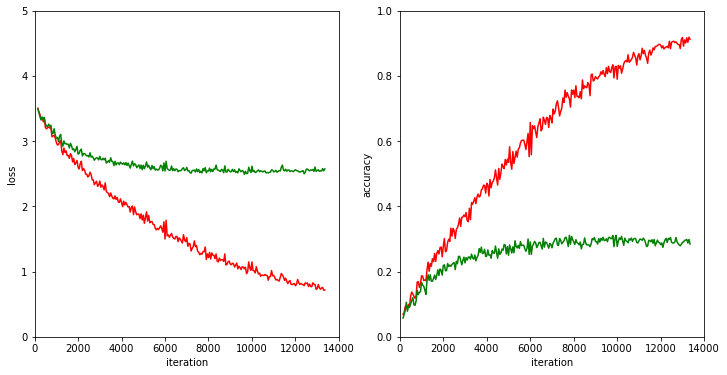

In [18]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,14000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,14000)
acc_graph.set_ylim(0,1)

plt.show()

# Model (7 layers)

In [11]:
class PetCNN7(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.4),
                                    nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),            
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.5),
                                    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),            
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        
        self.conv7 = nn.Sequential( nn.Dropout(0.6),
                                    nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),            
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.7),
                                    nn.Linear(1024, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.conv7(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN7()
loss_function = nn.NLLLoss()


print(model1)
        

PetCNN7(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.4, inplace=False)
    (1): Conv2d(32, 128,

In [14]:
#learning_rate = 0.001
#decay_rate = 0.0001
#optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 100

#iteration = 0
#iteration_list = []
#train_loss_iter=[]
#train_accuracy_iter=[]
#valid_loss_iter=[]
#valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_r1_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_r1_part = DataLoader(train_r1,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_r1_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()


Epoch:0
Iteration:8150
Time taken for the last 50 iterations: 13.071607828140259
Epoch:0
Iteration:8200
Time taken for the last 50 iterations: 12.839961528778076
Epoch:1
Iteration:8250
Time taken for the last 50 iterations: 12.69837236404419
Current training loss:2.9012911319732666
Current training accuracy:0.17822265625
Current validation loss:3.042595148086548
Current validation accuracy:0.13346746563911438
Epoch:1
Iteration:8300
Time taken for the last 50 iterations: 13.267559051513672
Current training loss:2.904477596282959
Current training accuracy:0.17041015625
Current validation loss:3.048661708831787
Current validation accuracy:0.15224681794643402
Epoch:2
Iteration:8350
Time taken for the last 50 iterations: 12.554232358932495
Current training loss:2.8272125720977783
Current training accuracy:0.1904296875
Current validation loss:3.0320074558258057
Current validation accuracy:0.15425889194011688
Epoch:2
Iteration:8400
Time taken for the last 50 iterations: 12.939526796340942
Cur

Current training loss:2.807039737701416
Current training accuracy:0.2001953125
Current validation loss:3.0540921688079834
Current validation accuracy:0.1488933563232422
Epoch:16
Iteration:9900
Time taken for the last 50 iterations: 15.58177900314331
Current training loss:2.7965071201324463
Current training accuracy:0.212890625
Current validation loss:2.991828203201294
Current validation accuracy:0.17035546898841858
Epoch:16
Iteration:9950
Time taken for the last 50 iterations: 16.647440910339355
Current training loss:2.750469923019409
Current training accuracy:0.22021484375
Current validation loss:2.96761155128479
Current validation accuracy:0.1743796169757843
Epoch:16
Iteration:10000
Time taken for the last 50 iterations: 17.096054315567017
Current training loss:2.726199150085449
Current training accuracy:0.220703125
Current validation loss:2.9562008380889893
Current validation accuracy:0.16767270863056183
Epoch:17
Iteration:10050
Time taken for the last 50 iterations: 16.667559385299

Epoch:30
Iteration:11500
Time taken for the last 50 iterations: 17.32107377052307
Current training loss:2.6625280380249023
Current training accuracy:0.24658203125
Current validation loss:3.0138959884643555
Current validation accuracy:0.17035546898841858
Epoch:30
Iteration:11550
Time taken for the last 50 iterations: 17.501781940460205
Current training loss:2.573091983795166
Current training accuracy:0.25927734375
Current validation loss:2.9394724369049072
Current validation accuracy:0.17639167606830597
Epoch:31
Iteration:11600
Time taken for the last 50 iterations: 17.643587589263916
Current training loss:2.6440343856811523
Current training accuracy:0.24462890625
Current validation loss:2.9078547954559326
Current validation accuracy:0.18846412003040314
Epoch:31
Iteration:11650
Time taken for the last 50 iterations: 18.38839340209961
Current training loss:2.638523817062378
Current training accuracy:0.24267578125
Current validation loss:2.974088430404663
Current validation accuracy:0.174

Current validation loss:2.9495632648468018
Current validation accuracy:0.18242789804935455
Epoch:45
Iteration:13150
Time taken for the last 50 iterations: 34.23892569541931
Current training loss:2.5024430751800537
Current training accuracy:0.29345703125
Current validation loss:2.8981611728668213
Current validation accuracy:0.19382964074611664
Epoch:45
Iteration:13200
Time taken for the last 50 iterations: 34.7665741443634
Current training loss:2.593848466873169
Current training accuracy:0.25048828125
Current validation loss:2.9577484130859375
Current validation accuracy:0.17102615535259247
Epoch:45
Iteration:13250
Time taken for the last 50 iterations: 36.15379762649536
Current training loss:2.5183682441711426
Current training accuracy:0.28173828125
Current validation loss:2.913607597351074
Current validation accuracy:0.18108652532100677
Epoch:46
Iteration:13300
Time taken for the last 50 iterations: 34.578168630599976
Current training loss:2.5770719051361084
Current training accuracy:

Current training loss:2.456446647644043
Current training accuracy:0.29443359375
Current validation loss:2.91776967048645
Current validation accuracy:0.17773306369781494
Epoch:59
Iteration:14800
Time taken for the last 50 iterations: 41.24899983406067
Current training loss:2.436023712158203
Current training accuracy:0.30517578125
Current validation loss:2.9320998191833496
Current validation accuracy:0.18242789804935455
Epoch:60
Iteration:14850
Time taken for the last 50 iterations: 40.47853970527649
Current training loss:2.410332679748535
Current training accuracy:0.31103515625
Current validation loss:2.9249422550201416
Current validation accuracy:0.19181756675243378
Epoch:60
Iteration:14900
Time taken for the last 50 iterations: 41.30632710456848
Current training loss:2.4557855129241943
Current training accuracy:0.30126953125
Current validation loss:2.9700634479522705
Current validation accuracy:0.17169684171676636
Epoch:61
Iteration:14950
Time taken for the last 50 iterations: 40.7360

Epoch:74
Iteration:16400
Time taken for the last 50 iterations: 47.788079261779785
Current training loss:2.285910129547119
Current training accuracy:0.3505859375
Current validation loss:2.9306726455688477
Current validation accuracy:0.2012072503566742
Epoch:74
Iteration:16450
Time taken for the last 50 iterations: 47.463810205459595
Current training loss:2.3070387840270996
Current training accuracy:0.35400390625
Current validation loss:2.9119627475738525
Current validation accuracy:0.19450034201145172
Epoch:74
Iteration:16500
Time taken for the last 50 iterations: 45.13676381111145
Current training loss:2.3458831310272217
Current training accuracy:0.32080078125
Current validation loss:2.907677412033081
Current validation accuracy:0.17639167606830597
Epoch:75
Iteration:16550
Time taken for the last 50 iterations: 57.63865280151367
Current training loss:2.313262462615967
Current training accuracy:0.3544921875
Current validation loss:2.891798496246338
Current validation accuracy:0.1951710

KeyboardInterrupt: 

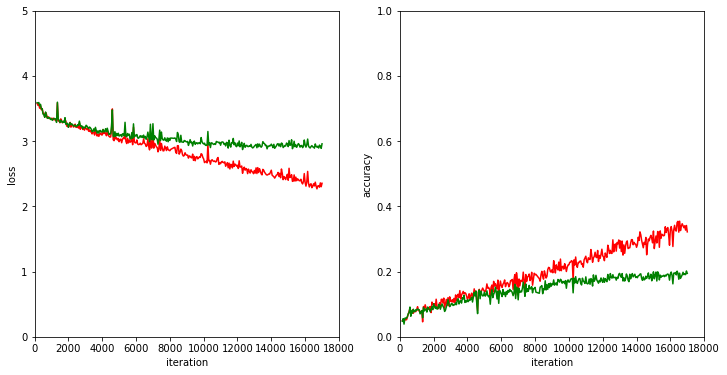

In [15]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,18000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,18000)
acc_graph.set_ylim(0,1)

plt.show()

So far it seems like, changing the regularization by a small amount isn't making a big difference as to the saturation value of validation accuracy. It looks quite likely that either the training dataset is not representative of the validation dataset (because of augmentation? or too noisy?) or that the training dataset is simply too small for the network to learn to distinguish between the different breeds, as within the same species the different breeds might look quite similar. 

Since the 6 layer network is the most successful one so far, we shall try once more with it, while keeping the dropout regularlization moderate/low, the weight decay a bit higher, and with a higher number of channels. We'll also add in one more dense layer.

# Model (6 conv layers, 2 dense layers, higher number of channels)

In [20]:
class PetCNN6ch(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.3),
                                    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.4),
                                    nn.Linear(1024, 370))
        
        self.dense2 = nn.Sequential(nn.Dropout(0.3),
                                    nn.Linear(370, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = self.dense2(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6ch()
loss_function = nn.NLLLoss()


print(model1)
        

PetCNN6ch(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(64, 25

In [21]:
learning_rate = 0.001
decay_rate = 0.0003
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 150

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_r1_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_r1_part = DataLoader(train_r1,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_r1_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

    


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 44.03653287887573
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 45.24963688850403
Epoch:1
Iteration:150
Time taken for the last 50 iterations: 44.5943329334259
Current training loss:3.5992672443389893
Current training accuracy:0.04638671875
Current validation loss:3.606135129928589
Current validation accuracy:0.036217302083969116
Epoch:1
Iteration:200
Time taken for the last 50 iterations: 46.20002603530884
Current training loss:3.461941957473755
Current training accuracy:0.08447265625
Current validation loss:3.4705941677093506
Current validation accuracy:0.07780013233423233
Epoch:2
Iteration:250
Time taken for the last 50 iterations: 45.60690903663635
Current training loss:3.4545016288757324
Current training accuracy:0.072265625
Current validation loss:3.4429256916046143
Current validation accuracy:0.08383635431528091
Epoch:2
Iteration:300
Time taken for the last 50 iterations: 51.78649973869324
Current trainin

Current training loss:2.180847644805908
Current training accuracy:0.40185546875
Current validation loss:2.5668632984161377
Current validation accuracy:0.28169015049934387
Epoch:16
Iteration:1800
Time taken for the last 50 iterations: 51.871010303497314
Current training loss:2.1324081420898438
Current training accuracy:0.41064453125
Current validation loss:2.560047149658203
Current validation accuracy:0.2709590792655945
Epoch:16
Iteration:1850
Time taken for the last 50 iterations: 54.51953625679016
Current training loss:2.1572988033294678
Current training accuracy:0.39404296875
Current validation loss:2.645009756088257
Current validation accuracy:0.2749832272529602
Epoch:16
Iteration:1900
Time taken for the last 50 iterations: 55.11741089820862
Current training loss:1.9049139022827148
Current training accuracy:0.46484375
Current validation loss:2.4796037673950195
Current validation accuracy:0.3078470826148987
Epoch:17
Iteration:1950
Time taken for the last 50 iterations: 52.84288048744

Epoch:30
Iteration:3400
Time taken for the last 50 iterations: 45.111714124679565
Current training loss:0.7478424906730652
Current training accuracy:0.828125
Current validation loss:2.467698574066162
Current validation accuracy:0.35680750012397766
Epoch:30
Iteration:3450
Time taken for the last 50 iterations: 46.34991979598999
Current training loss:0.7711824178695679
Current training accuracy:0.82958984375
Current validation loss:2.498443126678467
Current validation accuracy:0.3433936834335327
Epoch:31
Iteration:3500
Time taken for the last 50 iterations: 46.6917781829834
Current training loss:0.7741285562515259
Current training accuracy:0.80419921875
Current validation loss:2.5261144638061523
Current validation accuracy:0.3346747159957886
Epoch:31
Iteration:3550
Time taken for the last 50 iterations: 47.2614324092865
Current training loss:0.6629050374031067
Current training accuracy:0.85888671875
Current validation loss:2.41463303565979
Current validation accuracy:0.3601609766483307
E

KeyboardInterrupt: 

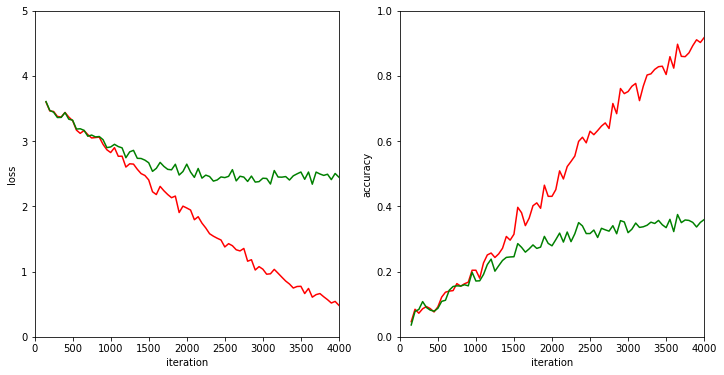

In [22]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,4000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,4000)
acc_graph.set_ylim(0,1)

plt.show()

# Model (4 conv layers, 3 dense layers, more channels)

In [23]:
class PetCNN4ch(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=4, stride=2),                                    
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=32, out_channels=256, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=2, stride=1),                                       
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout(0.3),
                                    nn.Conv2d(in_channels=256, out_channels=1024, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.4),
                                    nn.Linear(1024, 512))
        
        self.dense2 = nn.Sequential(nn.Dropout(0.4),
                                    nn.Linear(512, 256))
        
        self.dense3 = nn.Sequential(nn.Dropout(0.3),
                                    nn.Linear(256, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = self.dense2(out)
        out = self.dense3(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


loss_function = nn.NLLLoss()

model1 = PetCNN4ch()
print(model1)


learning_rate = 0.001
decay_rate = 0.0003
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 120

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_r1_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_r1_part = DataLoader(train_r1,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_r1_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                             

    

        

PetCNN4ch(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 32, kernel_size=(3, 3), stride=(2, 2))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(32, 256, kernel_size=(3, 3), stride=(2, 2))
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Conv2d(256, 1

Current validation loss:2.821335792541504
Current validation accuracy:0.1951710283756256
Epoch:12
Iteration:1450
Time taken for the last 50 iterations: 10.94806456565857
Current training loss:2.673389196395874
Current training accuracy:0.2587890625
Current validation loss:2.8396358489990234
Current validation accuracy:0.2065727710723877
Epoch:13
Iteration:1500
Time taken for the last 50 iterations: 10.833435773849487
Current training loss:2.693138360977173
Current training accuracy:0.23583984375
Current validation loss:2.846156120300293
Current validation accuracy:0.19450034201145172
Epoch:13
Iteration:1550
Time taken for the last 50 iterations: 10.973140954971313
Current training loss:2.6937263011932373
Current training accuracy:0.228515625
Current validation loss:2.8133106231689453
Current validation accuracy:0.2059020847082138
Epoch:14
Iteration:1600
Time taken for the last 50 iterations: 10.693832397460938
Current training loss:2.612297534942627
Current training accuracy:0.265625
C

Current training loss:2.0096309185028076
Current training accuracy:0.44287109375
Current validation loss:2.667530059814453
Current validation accuracy:0.25620388984680176
Epoch:27
Iteration:3100
Time taken for the last 50 iterations: 10.948774099349976
Current training loss:1.886643886566162
Current training accuracy:0.4892578125
Current validation loss:2.5606346130371094
Current validation accuracy:0.27833667397499084
Epoch:28
Iteration:3150
Time taken for the last 50 iterations: 10.657925367355347
Current training loss:1.9584592580795288
Current training accuracy:0.45751953125
Current validation loss:2.601994276046753
Current validation accuracy:0.2602280378341675
Epoch:28
Iteration:3200
Time taken for the last 50 iterations: 10.770243167877197
Current training loss:1.8631415367126465
Current training accuracy:0.50146484375
Current validation loss:2.5864508152008057
Current validation accuracy:0.2790073752403259
Epoch:29
Iteration:3250
Time taken for the last 50 iterations: 10.586470

Epoch:41
Iteration:4700
Time taken for the last 50 iterations: 11.288309574127197
Current training loss:1.212720274925232
Current training accuracy:0.72412109375
Current validation loss:2.457399845123291
Current validation accuracy:0.3125419318675995
Epoch:42
Iteration:4750
Time taken for the last 50 iterations: 10.974836587905884
Current training loss:1.340330719947815
Current training accuracy:0.66748046875
Current validation loss:2.5598647594451904
Current validation accuracy:0.29443326592445374
Epoch:42
Iteration:4800
Time taken for the last 50 iterations: 11.332303762435913
Current training loss:1.2365025281906128
Current training accuracy:0.7021484375
Current validation loss:2.525721788406372
Current validation accuracy:0.28906774520874023
Epoch:43
Iteration:4850
Time taken for the last 50 iterations: 11.126457452774048
Current training loss:1.222647786140442
Current training accuracy:0.71875
Current validation loss:2.5476341247558594
Current validation accuracy:0.285714298486709

Current validation loss:2.59749698638916
Current validation accuracy:0.29443326592445374


KeyboardInterrupt: 

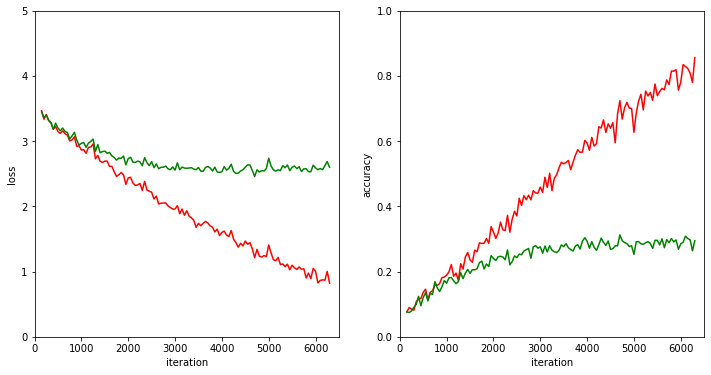

In [25]:

fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,6500)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,6500)
acc_graph.set_ylim(0,1)

plt.show()           
        
